In [27]:
import heapq
import math
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
from math import cos, sin, tan, pi

import Reeds_shepp_path as rs
import Vehicle
import Environment as Env
from Heuristic import create_heuristic_dict
from Vehicle import check_vehicle_collision


SB_COST = 100.0  # switch back penalty cost
BACK_COST = 5.0  # backward penalty cost
STEER_CHANGE_COST = 5.0  # steer angle change penalty cost
STEER_COST = 1.0  # steer angle change penalty cost
H_COST = 5.0  # Heuristic cost
N_STEER = 20 # number of steer command


class Global_Node:
    def __init__(self, x_d, y_d, yaw_d, direction, x_list, y_list, yaw_list, directions, steer=0.0, parent_index=None, cost=None):
        self.x_d = x_d
        self.y_d = y_d
        self.yaw_d = yaw_d
        self.direction = direction
        
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.directions = directions
        
        self.steer = steer
        self.parent_index = parent_index
        self.cost = cost
        
        
class Global_Path:
    def __init__(self, x_list, y_list, yaw_list, direction_list, cost):
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        self.direction_list = direction_list
        self.cost = cost


def Global_Hybrid_A_Star_Planning(start_pos, target_pos, obstacle_list):
    obstacle_kd_tree = cKDTree(np.array(obstacle_list))
    
    start_node = Global_Node(round(start_pos[0]), round(start_pos[1]), round(start_pos[2] / Env.YAW_RES), True, 
                             [start_pos[0]], [start_pos[1]], [start_pos[2]], [True], cost=0)
    target_node = Global_Node(round(target_pos[0]), round(target_pos[1]), round(target_pos[2] / Env.YAW_RES), True,
                              [target_pos[0]], [target_pos[1]], [target_pos[2]], [True])

    open_set, closed_set = {}, {}
    heuristic_set = create_heuristic_dict(target_pos[0], target_pos[1], obstacle_list)
    
    priority_q = []
    
    open_set[calc_index(start_node)] = start_node
    
    ## priority_q 에 h cost와 index를 집어넣는다.
    heapq.heappush(priority_q, (calc_cost(start_node, heuristic_set), calc_index(start_node)))
    
    final_path = None
    
    while True:
        if not open_set:
            print("Cannot find global path")
            return [], [], []
        
        cost, current_ind = heapq.heappop(priority_q)
        
        ## openset에서 가장 적은 cost를 가진 node를 closedset에 넣는다.
        if current_ind in open_set:
            current_node = open_set.pop(current_ind)
            closed_set[current_ind] = current_node
        else:  
            continue
        
        is_updated, final_path = update_node_with_analytic_expansion(current_node, target_node, obstacle_list, obstacle_kd_tree)
        
        if is_updated:
            print("path found!")
            break
        
        for neighbor in get_neighbors(current_node, obstacle_list, obstacle_kd_tree):
            neighbor_index = calc_index(neighbor)
            
            if neighbor_index in closed_set:
                continue
            if neighbor_index not in open_set or open_set[neighbor_index].cost > neighbor.cost:
                heapq.heappush(priority_q, (calc_cost(neighbor, heuristic_set), neighbor_index))
                open_set[neighbor_index] = neighbor
                
    path = get_final_path(closed_set, final_path)
    return path


def get_final_path(closed_set, target_node):
    reversed_x, reversed_y, reversed_yaw = \
        list(reversed(target_node.x_list)), list(reversed(target_node.y_list)), \
        list(reversed(target_node.yaw_list))
    direction = list(reversed(target_node.directions))
    nid = target_node.parent_ind
    final_cost = target_node.cost

    while nid:
        n = closed_set[nid]
        reversed_x.extend(list(reversed(n.x_list)))
        reversed_y.extend(list(reversed(n.y_list)))
        reversed_yaw.extend(list(reversed(n.yaw_list)))
        direction.extend(list(reversed(n.directions)))

        nid = n.parent_ind
        # if isinstance(nid, float):
        #     print(n.x_list)
        #     break
        # # if nid > 50000:
        # #     break

    reversed_x = list(reversed(reversed_x))
    reversed_y = list(reversed(reversed_y))
    reversed_yaw = list(reversed(reversed_yaw))
    direction = list(reversed(direction))

    # adjust first direction
    direction[0] = direction[1]

    path = Global_Path(reversed_x, reversed_y, reversed_yaw, direction, final_cost)

    return path

def update_node_with_analytic_expansion(current_node, target_node, obstacle_list, kd_tree):
    path = analytic_expansion(current_node, target_node, obstacle_list, kd_tree)
    
    if path:
        f_x = path.x[1:]
        f_y = path.y[1:]
        f_yaw = path.yaw[1:]

        f_cost = current_node.cost + calc_rs_path_cost(path)
        f_parent_index = calc_index(current_node)

        fd = []
        for d in path.directions[1:]:
            fd.append(d >= 0)

        f_path = Global_Node(current_node.x_d, current_node.y_d, current_node.yaw_d,
                            current_node.direction, f_x, f_y, f_yaw, fd,
                            steer = 0.0, cost=f_cost, parent_index=f_parent_index)
        return True, f_path

    return False, None

def analytic_expansion(current, goal, obstacle_list, kd_tree):
    start_x = current.x_list[-1]
    start_y = current.y_list[-1]
    start_yaw = current.yaw_list[-1]

    goal_x = goal.x_list[-1]
    goal_y = goal.y_list[-1]
    goal_yaw = goal.yaw_list[-1]

    paths = rs.calc_paths(start_x, start_y, start_yaw,
                          goal_x, goal_y, goal_yaw,
                          Vehicle.MAX_CURVATURE, step_size=Env.STEP_SIZE)

    if not paths:
        return None

    best_path, best = None, None

    for path in paths:
        if check_vehicle_collision(path.x, path.y, path.yaw, obstacle_list, kd_tree):
            cost = calc_rs_path_cost(path)
            if not best or best > cost:
                best = cost
                best_path = path

    return best_path

def get_neighbors(current, obstacle_list, kd_tree):
    for steer, d in calc_motion_inputs():
        node = calc_next_node(current, steer, d, obstacle_list, kd_tree)
        if node and verify_index(node):
            yield node    

def calc_index(node):
    ind = (node.yaw_d - Env.YAW_MIN) * Env.XWID * Env.YWID + \
          (node.y_d - Env.YMIN) * Env.XWID + (node.x_d - Env.XMIN)
    return ind

def calc_cost(node, heuristic_set):
    ind = (node.y_d - Env.YMIN) * Env.XWID + (node.x_d - Env.XMIN)
    if ind not in heuristic_set:
        return node.cost + 999999999
    return node.cost + H_COST * heuristic_set[ind].cost

def calc_motion_inputs():
    for steer in np.concatenate((np.linspace(-Vehicle.MAX_STEER, Vehicle.MAX_STEER, N_STEER), [0.0])):
        for d in [1, -1]:
            yield [steer, d]

def calc_rs_path_cost(reed_shepp_path):
    cost = 0.0
    for length in reed_shepp_path.lengths:
        if length >= 0:  # forward
            cost += length
        else:  # back
            cost += abs(length) * BACK_COST

    # switch back penalty
    for i in range(len(reed_shepp_path.lengths) - 1):
        # switch back
        if reed_shepp_path.lengths[i] * reed_shepp_path.lengths[i + 1] < 0.0:
            cost += SB_COST

    # steer penalty
    for course_type in reed_shepp_path.ctypes:
        if course_type != "S":  # curve
            cost += STEER_COST * abs(Vehicle.MAX_STEER)

    # ==steer change penalty
    # calc steer profile
    n_ctypes = len(reed_shepp_path.ctypes)
    u_list = [0.0] * n_ctypes
    for i in range(n_ctypes):
        if reed_shepp_path.ctypes[i] == "R":
            u_list[i] = - Vehicle.MAX_STEER
        elif reed_shepp_path.ctypes[i] == "L":
            u_list[i] = Vehicle.MAX_STEER

    for i in range(len(reed_shepp_path.ctypes) - 1):
        cost += STEER_CHANGE_COST * abs(u_list[i + 1] - u_list[i])

    return cost

def kinematic_move(x, y, yaw, distance, steer):
    x += distance * cos(yaw)
    y += distance * sin(yaw)
    yaw += rs.pi_2_pi(distance * tan(steer) / Vehicle.WB)
    
    return x, y, yaw

def calc_next_node(current, steer, direction, obstacle_list, kd_tree):
    x, y, yaw = current.x_list[-1], current.y_list[-1], current.yaw_list[-1]

    x_list, y_list, yaw_list = [], [], []

    x, y, yaw = kinematic_move(x, y, yaw, direction, steer)
    x_list.append(x)
    y_list.append(y)
    yaw_list.append(yaw)

    if not check_vehicle_collision(x_list, y_list, yaw_list, obstacle_list, kd_tree):
        return None

    d = direction == 1
    x_ind = round(x)
    y_ind = round(y)
    yaw_ind = round(yaw / Env.YAW_RES)

    added_cost = 0.0

    if d != current.direction:
        added_cost += SB_COST

    # steer penalty
    added_cost += STEER_COST * abs(steer)

    # steer change penalty
    added_cost += STEER_CHANGE_COST * abs(current.steer - steer)

    cost = current.cost + added_cost

    node = Global_Node(x_ind, y_ind, yaw_ind, d, x_list,
                y_list, yaw_list, [d], steer=steer,
                parent_index=calc_index(current),
                cost=cost)

    return node

def verify_index(node):
    x_ind, y_ind = node.x_d, node.y_d
    if Env.XMIN <= x_ind <= Env.XMAX and Env.YMIN <= y_ind <= Env.YMAX:
        return True
    
    return False

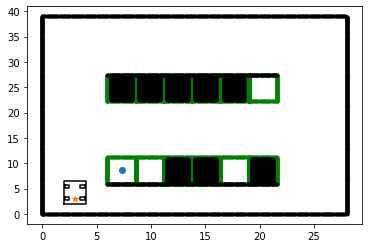

start :  [3, 3, 1.5707963267948966]
target :  [7.3, 8.6, -1.5707963267948966]


In [28]:
import numpy as np
import math
import Vehicle
import Environment as Env
import matplotlib.pyplot as plt
import random
import Heuristic

CAR_INIT_X = 3
CAR_INIT_Y = 3
CAR_INIT_YAW = 90 #deg

env = Env.Environment_1(Env.XMIN,Env.YMIN,Env.XMAX,Env.YMAX)
env.create_world_1()
env.plot_world()
veh = Vehicle.Vehicle(x = CAR_INIT_X, y = CAR_INIT_Y, yaw = np.deg2rad(90), v=0.0)
veh.plot_car(0)
plt.show()

obs_list = env.obstacle_list

start_pos = [veh.x, veh.y, veh.yaw]
target_pos = [env.target_x, env.target_y, np.deg2rad(-90.0)]

print("start : ", start_pos)
print("target : ", target_pos)

In [29]:
Global_path = Global_Hybrid_A_Star_Planning(start_pos, target_pos, obs_list)

KeyboardInterrupt: 

In [ ]:
env.plot_world(global_path=Global_path)
veh.plot_car(0)

In [6]:
import numpy as np

a = 3
b = 4
c = 3
d = 5

s = np.array((a,b))
t = np.array((c,d))
np.linalg.norm(s-t)

1.0